# Kaggle competition for Assignment 1

### <span style="color:#0b486b"> II.0 Running on Google Colab</span> <span style="color:red"></span>
You will need to download relevant files to run this notebook on Google Colab.

Backup link for the training set.

Backup link to download the test set.

In [1]:
!pip install torchsummary
import os
import requests
import tarfile
import time
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torchvision.models as models
import torch.nn as nn
import torch
import PIL.Image
import pathlib
from torchsummary import summary
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# check if CUDA is available
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")

device = get_device()
print("Using device:", device)

Using device: cuda


In [2]:
import random
def seed_all(seed=1029):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
seed_all(1029)

## Data Preprocess

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, TensorDataset
import torch
from torchvision.transforms import InterpolationMode
data_dir = "/notebooks/data/fit5215/FIT5215_Dataset"

# We resize the images to [3,64,64]
IMNET_MEAN = [0.485, 0.456, 0.406]
IMNET_STD  = [0.229, 0.224, 0.225]

# We resize the images to [3,64,64]
transform = transforms.Compose([
    transforms.Resize((64,64)),                    # resize to 64×64
    transforms.RandomHorizontalFlip(),             # horizontal flip
    transforms.ColorJitter(0.2, 0.2, 0.2),         # color jitter
    transforms.ToTensor(),                         # to tensor
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5)),         # normalize
])

# --- helper: detect device (cuda > mps > cpu) ---
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")

device = get_device()

# Load the dataset using torchvision.datasets.ImageFolder and apply transformations
dataset = datasets.ImageFolder(data_dir, transform=transform)

# Split the dataset into training and validation sets (same 90/10 split)
train_size = int(0.9 * len(dataset))
valid_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, valid_size])

# --- minimal-change preload: read each split once, stack, then move to device ---
@torch.no_grad()
def preload_to_device(subset, device, tmp_bs=1024):
    """
    One-pass preload: iterate the Subset once on CPU, then move to device.
    tmp_bs does not affect your final DataLoader batch size (kept at 32).
    """
    tmp_loader = DataLoader(subset, batch_size=tmp_bs, shuffle=False, num_workers=0)
    xs, ys = [], []
    for xb, yb in tmp_loader:
        xs.append(xb.to(device))      # move batch to device
        ys.append(yb.to(device))
    X = torch.cat(xs, dim=0)          # [N, 3, 64, 64] on device
    Y = torch.cat(ys, dim=0)          # [N] on device
    return X, Y

train_X, train_Y = preload_to_device(train_dataset, device)
val_X,   val_Y   = preload_to_device(val_dataset,   device)

# Wrap back into TensorDataset on device
train_tensor_ds = TensorDataset(train_X, train_Y)
val_tensor_ds   = TensorDataset(val_X,   val_Y)

# Example of DataLoader creation for training and validation
# (keep exactly the same batch_size and shuffle settings as your original code)
train_loader = DataLoader(train_tensor_ds, batch_size=32, shuffle=True,  num_workers=0, pin_memory=False)
val_loader   = DataLoader(val_tensor_ds,   batch_size=32, shuffle=False, num_workers=0, pin_memory=False)

print("Number of instance in train_set: %s" % len(train_tensor_ds))
print("Number of instance in val_set: %s"   % len(val_tensor_ds))

In [ ]:
# ===== Unlabeled test set: one-shot preload to GPU/MPS, keep DataLoader API =====
import os
from pathlib import Path
from PIL import Image
import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms

# --- 1) Device (if you already have a device in the code, you don't need this section) ---
if 'device' not in globals():
    def get_device():
        if torch.cuda.is_available():
            return torch.device("cuda")
        if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
            return torch.device("mps")
        return torch.device("cpu")
    device = get_device()
print("Unlabeled set will be cached on:", device)

# --- 2) Unlabeled data set: collect all pictures recursively, no class folder structure is required ---
class UnlabeledImageDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None, exts=(".jpg", ".jpeg", ".png", ".bmp", ".webp")):
        self.root = Path(root)
        self.paths = sorted([p for p in self.root.rglob("*") if p.suffix.lower() in exts])
        if len(self.paths) == 0:
            raise RuntimeError(f"No images found under: {root}")
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        if self.transform is not None:
            img = self.transform(img)
        return img  # 注意：只有图像，没有标签

# --- 3) 与训练一致的“非增强”变换（可按你的需要改；半监督里通常用弱增强） ---
unlabeled_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

test_data_dir = "/notebooks/data/fit5215/test_set"  # 你的无标签图像根目录
unlabeled_ds = UnlabeledImageDataset(test_data_dir, transform=unlabeled_transform)
print(f"[Unlabeled] found {len(unlabeled_ds)} images.")

# --- 4) 一次性预加载到 GPU/MPS ---
@torch.no_grad()
def preload_unlabeled_to_device(ds, device, tmp_bs=1024, workers=2):
    """
    一次性预加载：仅在 CPU 上读取/解码一次，然后搬到 device 并拼接成大张量。
    tmp_bs 只影响预加载速度，不影响你后续 DataLoader 的 batch_size。
    """
    tmp_loader = DataLoader(ds, batch_size=tmp_bs, shuffle=False,
                            num_workers=workers, pin_memory=True, drop_last=False)
    chunks = []
    for xb in tmp_loader:
        # ds 返回的就是图像张量 batch
        chunks.append(xb.to(device, non_blocking=True))
    X = torch.cat(chunks, dim=0)          # [N, 3, 64, 64] on device
    return X

unlabeled_X = preload_unlabeled_to_device(unlabeled_ds, device, tmp_bs=1024, workers=0)
print(f"[Unlabeled] cached tensor on {device}: {tuple(unlabeled_X.shape)}")

# 可选：在 CUDA 上想省显存可以半精度（如果后续模型也用 AMP/FP16）
# if device.type == "cuda":
#     unlabeled_X = unlabeled_X.half()

# --- 5) 包装成 TensorDataset，并加“虚拟标签”(-1)，保持 (inputs, targets) API 一致 ---
dummy_Y = torch.full((unlabeled_X.size(0),), -1, dtype=torch.long, device=device)
unlabeled_tensor_ds = TensorDataset(unlabeled_X, dummy_Y)

# --- 6) DataLoader：数据已经在 GPU/MPS，num_workers=0、pin_memory=False ---
unsup_batch_size = train_loader.batch_size if 'train_loader' in globals() else 64
unlabeled_loader = DataLoader(
    unlabeled_tensor_ds,
    batch_size=unsup_batch_size,
    shuffle=True,          # 无标签可打乱
    num_workers=0,         # 关键：GPU/MPS 张量不能再多进程
    pin_memory=False,
    drop_last=True
)
print(f"[Unlabeled] loader ready. batch_size={unsup_batch_size}, steps/epoch={len(unlabeled_loader)}")

Unlabeled set will be cached on: cuda
[Unlabeled] found 16167 images.
[Unlabeled] cached tensor on cuda: (16167, 3, 224, 224)
[Unlabeled] loader ready. batch_size=32, steps/epoch=505


In [5]:
class_names = ['birds', 'bottles', 'breads', 'butterflies', 'cakes', 'cats', 'chickens', 'cows', 'dogs', 'ducks',
                  'elephants', 'fishes', 'handguns', 'horses', 'lions', 'lipsticks', 'seals', 'snakes', 'spiders', 'vases']

In [6]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

# >>> FIX: move to CPU before numpy
images = images.detach().cpu().numpy()  # [B, 3, 64, 64]

In [7]:
import math

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

def visualize_data(images, categories, images_per_row = 8):
    class_names = ['birds', 'bottles', 'breads', 'butterflies', 'cakes', 'cats', 'chickens', 'cows', 'dogs', 'ducks',
                  'elephants', 'fishes', 'handguns', 'horses', 'lions', 'lipsticks', 'seals', 'snakes', 'spiders', 'vases']
    n_images = len(images)
    n_rows = math.ceil(float(n_images)/images_per_row)
    fig = plt.figure(figsize=(1.5*images_per_row, 1.5*n_rows))
    fig.patch.set_facecolor('white')
    for i in range(n_images):
        plt.subplot(n_rows, images_per_row, i+1)
        plt.xticks([])
        plt.yticks([])
        imshow(images[i])
        class_index = categories[i]
        plt.xlabel(class_names[class_index])
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

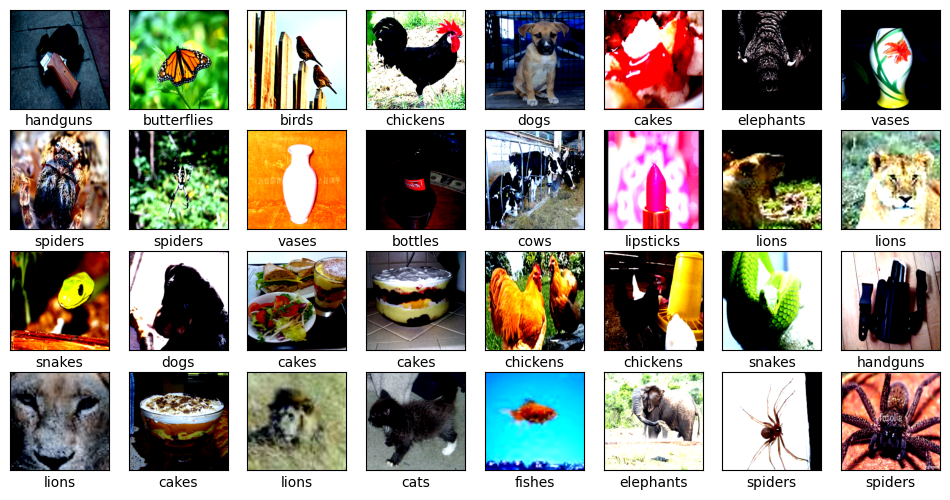

In [22]:
visualize_data(images, labels)

In [8]:
count_class = {}
for _,outs in dataset:
    labels = class_names[outs]
    if labels not in count_class:
        count_class[labels] = 0
    count_class[labels] += 1
count_class

{'birds': 512,
 'bottles': 432,
 'breads': 432,
 'butterflies': 500,
 'cakes': 432,
 'cats': 501,
 'chickens': 500,
 'cows': 500,
 'dogs': 501,
 'ducks': 496,
 'elephants': 500,
 'fishes': 500,
 'handguns': 448,
 'horses': 500,
 'lions': 500,
 'lipsticks': 400,
 'seals': 448,
 'snakes': 496,
 'spiders': 500,
 'vases': 368}

## Define Models

In [9]:
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    # MPS available on Apple Silicon (PyTorch >= 1.12)
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")

device = get_device()
print("Using device:", device)

Using device: cuda


In [10]:
def compute_loss(model, loss_fn, loader):
  loss = 0
  # Set model to eval mode for inference
  model.eval()
  with torch.no_grad():  # No need to track gradients for validation
    for (batchX, batchY) in loader:
      # Move data to the same device as the model
      batchX, batchY = batchX.to(device).type(torch.float32), batchY.to(device).type(torch.long)
      loss += loss_fn(model(batchX), batchY)
  # Set model back to train mode
  model.train()
  return float(loss)/len(loader)

In [11]:
def compute_acc(model, loader):
    correct = 0
    totals = 0
    # Set model to eval mode for inference
    model.eval()
    for (batchX, batchY) in loader:
        # Move batchX and batchY to the same device as the model
        batchX, batchY = batchX.to(device).type(torch.float32), batchY.to(device)
        outputs = model(batchX)  # feed batch to the model
        totals += batchY.size(0)  # accumulate totals with the current batch size
        predicted = torch.argmax(outputs.data, 1)  # get the predicted class
        # Move batchY to the same device as predicted for comparison
        correct += (predicted == batchY).sum().item()
    return correct / totals

Here are some example CNNs for the demonstration purpose. You should use your own developed network for the competition.

## Training the Model

### Model Selection

#### <span style="color:#0b486b">4. Declaring the Loss, Optimizer, learning rate and Training the Model </span>

In [18]:
# ============================================================================
# SIMPLE VIT-ONLY TRAINING CODE FOR COMPARISON
# ============================================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import vit_b_16, ViT_B_16_Weights
from torchvision.models import vit_h_14, ViT_H_14_Weights
import pandas as pd
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def simple_vit_pipeline(train_loader, val_loader, test_loader, device, epochs=15):
    """
    Simple ViT training without any ensemble or complex techniques
    """

    print("="*80)
    print("SIMPLE VIT-ONLY TRAINING")
    print("="*80)

    # Step 1: Create simple ViT model
    weights = ViT_H_14_Weights.IMAGENET1K_SWAG_LINEAR_V1
    model = vit_h_14(weights=weights)
    
    # Freeze most layers
    for name, param in model.named_parameters():
        if not ('blocks.11' in name or 'heads' in name):
            param.requires_grad = False

    # Replace classifier
    in_feats = model.heads.head.in_features  # =1280
    model.heads.head = nn.Linear(in_feats, 20)
    model = model.to(device)

    # Step 2: Train with simple settings
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
    criterion = nn.CrossEntropyLoss()

    print("\nTraining Phase:")
    print("-"*40)

    best_val_acc = 0

    for epoch in range(epochs):
        # Training
        model.train()
        train_correct = 0
        train_total = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            # Resize to 224x224 for ViT
            data = F.interpolate(data, size=(224, 224), mode='bilinear')

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            _, predicted = output.max(1)
            train_total += target.size(0)
            train_correct += predicted.eq(target).sum().item()

        # Validation
        model.eval()
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for data, target in val_loader:
                data = F.interpolate(data, size=(224, 224), mode='bilinear')
                output = model(data)
                _, predicted = output.max(1)
                val_total += target.size(0)
                val_correct += predicted.eq(target).sum().item()

        train_acc = train_correct / train_total
        val_acc = val_correct / val_total

        print(f"Epoch {epoch+1:2d}: Train: {train_acc:.4f}, Val: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()
            
            torch.save(best_model_state, "best_vit_h_224.pth")
    # Load best model
    #model.load_state_dict(best_model_state)

    # Step 3: Test set prediction
    print(f"\nBest Validation Accuracy: {best_val_acc:.4f}")
    print("\nGenerating Test Predictions...")
    print("-"*40)

    model.eval()
    all_predictions = []

    with torch.no_grad():
        for batch_idx, (data, _) in enumerate(test_loader):
            data = data.to(device)
            data = F.interpolate(data, size=(224, 224), mode='bilinear')

            # Simple prediction without TTA
            output = model(data)
            predictions = output.argmax(dim=1)
            all_predictions.append(predictions.cpu())

            if (batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {batch_idx+1}/{len(test_loader)}")

    # Concatenate predictions
    all_predictions = torch.cat(all_predictions).numpy()

    # Step 4: Create submission
    class_names = ['birds', 'bottles', 'breads', 'butterflies', 'cakes',
                   'cats', 'chickens', 'cows', 'dogs', 'ducks',
                   'elephants', 'fishes', 'handguns', 'horses', 'lions',
                   'lipsticks', 'seals', 'snakes', 'spiders', 'vases']

    submission = pd.DataFrame({
        'ID': range(len(all_predictions)),
        'Label': [class_names[pred] for pred in all_predictions]
    })

    submission.to_csv('submission_vit_h.csv', index=False)

    print("\n" + "="*80)
    print("RESULTS SUMMARY")
    print("="*80)
    print(f"Best Validation Accuracy: {best_val_acc:.4f}")
    print(f"Test Predictions: {len(all_predictions)}")
    print(f"Submission saved to: submission_vit_only.csv")
    print("\nPrediction Distribution:")
    print(submission['Label'].value_counts())

    return model, best_val_acc

# ============================================================================
# RUN SIMPLE VIT
# ============================================================================

if __name__ == "__main__":
    # Load test data
    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    testset = datasets.ImageFolder('/notebooks/data/fit5215/test_set', transform=test_transform)
    test_loader = DataLoader(testset, batch_size=500, shuffle=False, num_workers=0)

    # Run simple ViT
    vit_model, vit_acc = simple_vit_pipeline(
        train_loader,
        val_loader,
        test_loader,
        device,
        epochs=6
    )

    print("\n" + "="*80)
    print("COMPARISON")
    print("="*80)
    print(f"Single ViT Model: ~{vit_acc:.1%} validation")
    print(f"Your 7-Model Ensemble: 89.86% validation")
    print("\nExpected Test Performance:")
    print(f"- Single ViT: ~{vit_acc*0.95:.1%} (5% drop expected)")
    print(f"- 7-Model Ensemble: ~85% (as you've seen)")

SIMPLE VIT-ONLY TRAINING

Training Phase:
----------------------------------------
Epoch  1: Train: 0.9014, Val: 0.9937
Epoch  2: Train: 0.9946, Val: 0.9947
Epoch  3: Train: 0.9954, Val: 0.9958
Epoch  4: Train: 0.9964, Val: 0.9947
Epoch  5: Train: 0.9972, Val: 0.9947
Epoch  6: Train: 0.9977, Val: 0.9947

Best Validation Accuracy: 0.9958

Generating Test Predictions...
----------------------------------------
  Processed batch 10/33
  Processed batch 20/33
  Processed batch 30/33

RESULTS SUMMARY
Best Validation Accuracy: 0.9958
Test Predictions: 16167
Submission saved to: submission_vit_only.csv

Prediction Distribution:
Label
elephants      1326
cats           1232
butterflies    1130
dogs           1103
fishes         1074
lions          1072
horses         1032
spiders        1011
chickens        948
cows            862
ducks           573
breads          570
lipsticks       566
cakes           566
handguns        542
bottles         532
vases           529
birds           523
seals